In [1]:
import matplotlib
from tqdm import tqdm
import sys
sys.path.append('..')
from scipy import signal, stats, io
from ipywidgets import HBox, VBox
import ipywidgets as widgets
from neurolib.models.wc import WCModel
from task_fc_simulation.onset_design_model import WCOnsetDesign, HRF
from task_fc_simulation.read_utils import read_onsets_from_input
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 12
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2

# Bold simulation with  using the Balloon-Windkessel model


The Balloon-Windkessel model assumes that the BOLD signal is a static nonlinear function of the normalized total deoxyhemoglobin voxel content, normalized venous volume, resting net oxygen extraction fraction by the capillary bed, and resting blood volume fraction. 

The BOLD signal [(Friston et all, 2003)](https://doi.org/10.1016/S1053-8119(03)00202-7) is taken to be a static nonlinear function of volume and deoxyhemoglobin
that comprises a volume-weighted sum of extra- and intravascular signals. For the $i_{th}$ region, neuronal activity $Z_i$ causes an increase in a vasodilatory signal $X_i$ that is subject to autoregulatory
feedback. Inflow $F_i$ responds in proportion to this
signal with concomitant changes in blood volume $V_i$ and
deoxyhemoglobin content $Q_i$

$$ \frac{d(X_i)}{dt} = Z_i-k*X_i-\gamma_i(F_i-1) \\
\frac{d(F_i)}{dt}  = X_i \\
\tau \frac{d(V_i)}{dt} = F_i-V_i^{1/\alpha} \\
\tau\frac{d(Q_i)}{dt} = F_i*(1-(1-\rho)^{1/F_i})/\rho_i - V_i^{1/\alpha-1}Q_i$$

$$y_i =V_0*(k_1(1-Q_i)+k_2(1-\frac{Q_i}{V_i}+k_3*(1-V_i))) $$

| Parameter | Description                        | Prior mean   | Prior variance |
|-----------|------------------------------------|--------------|----------------|
| k         | rate of signal decay               | 0.65 per sec | 0.015          |
| gamma     | rate of flow dependant elimination | 0.41 per sec | 0.002          |
| tau       | Hemodynamic transit time           | 0.98 s       | 0.0568         |
| alpha     | Grubb's exponent                   | 0.32         | 0.0015         |
| rho       | Resting oxygen extraction fraction | 0.34         | 0.0024         |
| V_0       | Resting blood volume fraction      | 0.02         |                |
| k1        |                                    | 7*rho        |                |
| k2        |                                    | 2            |                |
| k3        |                                    | 2*rho-0.2    |                |

## Balloon-Windkessel model parameter setting

In [2]:
gamma = widgets.FloatSlider(min=0, max=2, step = 0.01, description='gamma', value=0.41, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
k = widgets.FloatSlider(min=0, max=2, step = 0.01, description='k', value=0.65, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
rho = widgets.FloatSlider(min=0, max=0.98,step = 0.01, description='rho', value=0.34, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
alpha = widgets.FloatSlider(min=0, max=2, step = 0.01, description='alpha', value=0.32, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
V0 = widgets.FloatSlider(min=0, max=0.5, step = 0.005, description='V0', value=0.02, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
tau = widgets.FloatSlider(min=0, max=2, step = 0.01, description='tau', value=0.98, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
k1_mul = widgets.FloatSlider(min=3, max=10, step = 0.1, description='k1_mul', value=7, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
k2 = widgets.FloatSlider(min=0, max=5, step = 0.1, description='k2', value=2, layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})

row1 = HBox([k, gamma])
row2 = HBox([rho, alpha])
row3 = HBox([V0, tau])
row4 = HBox([k1_mul, k2])

ui = VBox( [row1, row2, row3, row4] )


## Convolution with zero signal

Maximum achived at 0.0 second


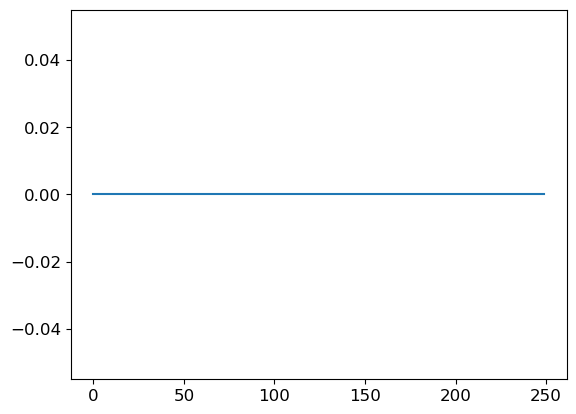

In [3]:
bw_params = {"rho": rho.value, "alpha": alpha.value, "V0": V0.value, "k1_mul": k1_mul.value,
                     "k2": k2.value, "k3_mul": None, "gamma": gamma.value, "k": k.value, "tau":tau.value}
TR = 0.1
dt = 10
local_activations = np.zeros((1,2500))
hrf = HRF(1, dt=dt, TR=TR, normalize_max=0.5)

hrf.bw_convolve(local_activations, append=False, **bw_params)
plt.plot(hrf.BOLD[0])
print(f"Maximum achived at {np.argmax(hrf.BOLD[0])*TR} second")

## Convolution of simple task design

Input parameters:
 - N (int): Number of nodes (for each node could be node specific design) 
 - onsets (list of list of int or list): onset list for each region, for example [10, 12, 15], N lists
 - duration (float or list of lists): duration of each task (in seconds)
 - last_rest (float): duration of the last rest part, in seconds
 - dt (float): sampling rate for activations, in ms (!!!)
 - TR (float): sampling rate for BOLD (in seconds)(!!!)
 - normalize_max(float): scaling factor for activation, multiplied before convolution with bold 
 
### Toy example for two nodes  

In [4]:
N=2
TR=0.5
dt=10

def draw_toy_bold_activation(**bw_param_dict):
    first_rest = 6
    onsets = [[5, 14, 25], [10, 20]]
    hrf = HRF(N, dt=dt, TR=TR, normalize_max=0.5)
    local_activation = hrf.create_task_design_activation(onsets, duration=2,
                                                             first_rest=first_rest, last_rest=5)
    hrf.bw_convolve(local_activation, append=False, **bw_param_dict)
    t_res_activ, res_activ = hrf.resample_to_TR(local_activation)

    fig, axs = plt.subplots(1, 2, figsize = (15,4))
    axs[0].plot(t_res_activ/1e3,0.03*res_activ[0,:]);
    axs[0].plot(t_res_activ/1e3, hrf.BOLD[0]); axs[0].set_title("Bold and resampled activation for first node");
    axs[0].set_xlabel("Time in sec")
    axs[1].plot(t_res_activ/1e3,0.03*res_activ[1,:]);
    axs[1].plot(t_res_activ/1e3, hrf.BOLD[1]); axs[1].set_title("Bold and resampled activation for second node");
    axs[1].set_xlabel("Time in sec")


ui = VBox( [row1, row2, row3, row4] )
bw_param_dict = {"rho": rho, "alpha": alpha, "V0": V0, "k1_mul": k1_mul,
                     "k2": k2, "gamma": gamma, "k": k, "tau":tau}
out = widgets.interactive_output(draw_toy_bold_activation, bw_param_dict)
display(ui, out)    

Output()

## Example with the real onsets

 - realization additive local activity TaskDesign*HRF

In [5]:
mat_path = '../data/SOTs_1.5s_duration.mat'
input_data = io.loadmat(mat_path)
print(input_data.keys())
print("Additional activation: ",input_data["activations"])

dict_keys(['__header__', '__version__', '__globals__', 'activations', 'durations', 'names', 'onsets', 'rest_matrix', 'task_matrices'])
Additional activation:  [[array([[1, 1, 0]], dtype=uint8) array([[0, 1, 1]], dtype=uint8)]]


Here we have next additional local activation:
 - for first block: taskA
 - for second block: taskB+taskA
 - for third block: taskB

so we need to create onset list for all these blocks

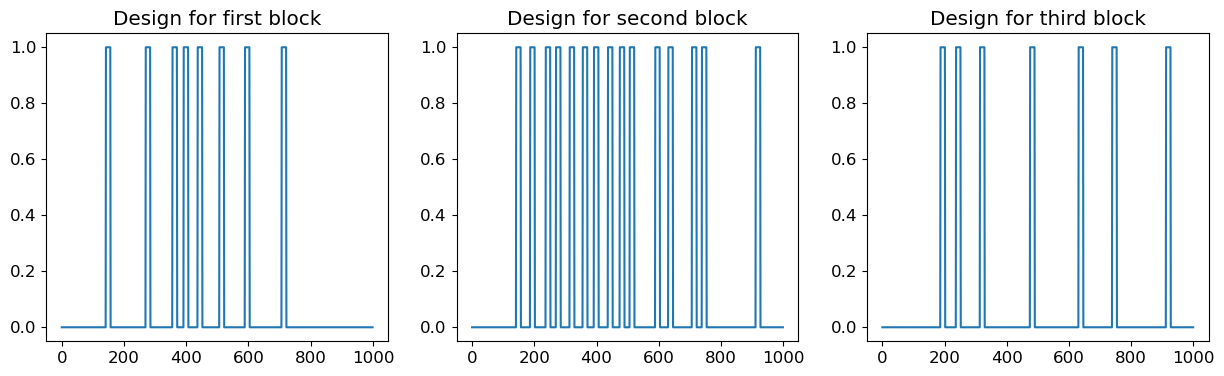

In [6]:
N=30
onset_taskA = list(input_data['onsets'][0, 0].squeeze().round(2))
onset_taskB = list(input_data['onsets'][0, 1].squeeze().round(2))
onset_taskAB,_,_ = read_onsets_from_input(mat_path)
onset_taskAB = list(onset_taskAB)
onsets = [onset_taskA]*(N//3)+[onset_taskAB]*(N//3)+[onset_taskB]*(N//3)
first_rest = 6
activity_scaling = 0.5
TR=1
dt=10
task_duration = float(input_data["durations"][0,0].squeeze())
step = int(TR*1e3//dt)
hrf = HRF(N, dt=dt, TR=TR, normalize_max=50)

local_activation = hrf.create_task_design_activation(onsets, duration=task_duration,
                                                          first_rest=first_rest, last_rest=6)
fig, axs = plt.subplots(1, 3, figsize = (15,4))
axs[0].plot(local_activation[0, :10000:10]); axs[0].set_title("Design for first block");
axs[1].plot(local_activation[10,:10000:10]); axs[1].set_title("Design for second block");
axs[2].plot(local_activation[20,:10000:10]); axs[2].set_title("Design for third block");

## Set up parameters for BW

You need to choose with the widgets

In [7]:
display(ui)   

In [8]:
bw_params ={"rho": rho.value, "alpha": alpha.value, "V0": V0.value, "k1_mul": k1_mul.value,
                     "k2": k2.value, "gamma": gamma.value, "k": k.value, "tau":tau.value}
print(f"The next parameters will be used for BOLD {bw_params}")

The next parameters will be used for BOLD {'rho': 0.34, 'alpha': 0.32, 'V0': 0.02, 'k1_mul': 7.0, 'k2': 2.0, 'gamma': 0.41, 'k': 0.65, 'tau': 0.98}


In [107]:
input_data['onsets'][0,0].shape

(117, 1)

In [10]:
N=30
onset_taskA = list(input_data['onsets'][0, 0].squeeze().round(2))
onset_taskB = list(input_data['onsets'][0, 1].squeeze().round(2))
onset_taskAB,_,_ = read_onsets_from_input(mat_path)
onset_taskAB = list(onset_taskAB)
onsets = [onset_taskA] * (N // 3) + \
         [onset_taskAB] * (N // 3) + \
         [onset_taskB] * (N // 3)
first_rest = 6
activity_scaling = 0.5
TR=1
dt=10

def draw_bold_responce_design(TR=1, draw_last = 50, act_scaling = activity_scaling):
    hrf = HRF(N, dt=dt, TR=TR, normalize_max=act_scaling )
    local_activation = hrf.create_task_design_activation(onsets, duration=task_duration,
                                                          first_rest=first_rest, last_rest=6)
    hrf.bw_convolve(local_activation, append=False, **bw_params)
    t_res_activ, res_activ = hrf.resample_to_TR(local_activation)
    fig, axs = plt.subplots(1, 3, figsize = (15,4))
    node_ids = [0,10,20]

    draw_last_TR = int(draw_last/TR) #in seconds
    for i in range(3):
        
        axs[i].plot(t_res_activ[-draw_last_TR:]/1e3, 0.03*res_activ[node_ids[i],-draw_last_TR:]);
        axs[i].plot(t_res_activ[-draw_last_TR:]/1e3, hrf.BOLD[node_ids[i],-draw_last_TR:]); 
        axs[i].set_title(f"Bold and resampled act for {node_ids[i]} node");

TR = widgets.FloatSlider(value = 1, min = 0.1, max = 2, step = 0.1, description = "TR")
draw_last = widgets.FloatSlider(value = 50, min = 1, max = 1000, step = 1, description = "ShowLast(s)")
act_scaling = widgets.FloatSlider(value = activity_scaling, min = 0.1, max = 1, step = 0.1, description = "ScAct")
row= HBox([TR, draw_last, act_scaling])        
out = widgets.interactive_output(draw_bold_responce_design, {"TR": TR, "draw_last": draw_last, "act_scaling": act_scaling})
display(row, out)          


Output()

# Перебор параметров

In [3]:
from scipy.optimize import least_squares
import numpy as np

In [5]:
mat_path = '../data/SOTs_1.5s_duration.mat'
input_data = io.loadmat(mat_path)

In [6]:
N=3
onset_taskA = list(input_data['onsets'][0, 0].squeeze().round(2))
onset_taskB = list(input_data['onsets'][0, 1].squeeze().round(2))
onset_taskAB,_,_ = read_onsets_from_input(mat_path)
onset_taskAB = list(onset_taskAB)
onsets = [onset_taskA] * (N//3)+\
         [onset_taskAB] * (N//3)+\
         [onset_taskB] * (N//3)
TR = 0.1 #s
dt = 10  #ms

In [7]:
hrf_gamma = HRF(N, dt=dt, TR=TR)
local_activation = hrf_gamma.create_task_design_activation(onsets,
                                                     duration=1.5,
                                                     first_rest=5,
                                                     last_rest=5)

### поиск эвентов

ищу, с какого индекса начинаются 1, потом после единиц ищу нули. проверяю, чтобы в диапазоне была только одна единица


In [8]:
for i in range(local_activation.shape[1]):
    if local_activation[0][i] == 1.0:
        print(i)
        break

1311


In [9]:
for i in range(1311, 1311+320):
    if local_activation[0][i] == 0.0:
        print(i-1)
        break

1460


In [51]:
sum(local_activation[1][1918:1918+320])

1.0

In [52]:
local_activation_320 = np.zeros((3, 320))
local_activation_320[0] = local_activation[0][1460:1460+320]
local_activation_320[1] = local_activation[1][1918:1918+320]
local_activation_320[2] = local_activation[2][1918:1918+320]

### _______________________

In [74]:
gamma_params = {"length": 32, "peak": 6, "undershoot": 16, "beta": 0.1667, "scaling": 0.6}
hrf_gamma.gamma_convolve(local_activation_320, append=False, **gamma_params)
gamma = hrf_gamma.BOLD[0]

In [75]:
gamma.shape

(32,)

In [76]:
def calc_corr(x0, gamma=gamma):
    hrf = HRF(N, dt=dt, TR=TR)
    bw_params ={"rho": x0[0], "alpha": x0[1], "V0": V0.value, "k1_mul": k1_mul.value,
                "k2": k2.value, "gamma": x0[2], "k": x0[3], "tau": x0[4]}
    hrf.bw_convolve(local_activation_320, append=False, **bw_params)
    balloon = hrf.BOLD[0]
    result = np.corrcoef(gamma/np.max(gamma)*0.6, balloon/np.max(balloon)*0.6)[0, 1]
    return result


Оптимизация параметров с помощью метода наименьших квадратов.

Считается корреляция между gamma и balloon при некоторых параметрах х. Парметры оптимизируются так, чтобы ошибка (1 - corr)**2 уменьшалась

In [77]:
def se(x0):
    return (1 - calc_corr(x0))**2

In [78]:
x0 = [0.34, 0.32, 0.41, 0.65, 0.98]
bounds = ([0, 0, 0, 0, 0], [2, 2, 2, 2, 0.98])
output = least_squares(se, x0, bounds=bounds)
print(output)
x = output.x
# x -- полученные параметры

 active_mask: array([0, 0, 0, 0, 1])
        cost: 3.8776690488511683e-10
         fun: array([0.00002785])
        grad: array([ 0.00000002, -0.00000001,  0.        ,  0.        , -0.        ])
         jac: array([[ 0.00067626, -0.00025106,  0.0000059 ,  0.00007598, -0.00015003]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 85
        njev: 69
  optimality: 9.470287522836725e-09
      status: 1
     success: True
           x: array([0.5028607 , 0.78354397, 0.335946  , 0.57944846, 0.98      ])


In [79]:
calc_corr(x)

0.9947228409470358

In [80]:
hrf = HRF(N, dt=dt, TR=TR)
bw_params ={"rho": x[0], "alpha": x[1], "V0": V0.value, "k1_mul": k1_mul.value,
            "k2": k2.value, "gamma": x[2], "k": x[3], "tau": x[4]}
hrf.bw_convolve(local_activation_320, append=False, **bw_params)
balloon = hrf.BOLD[0]

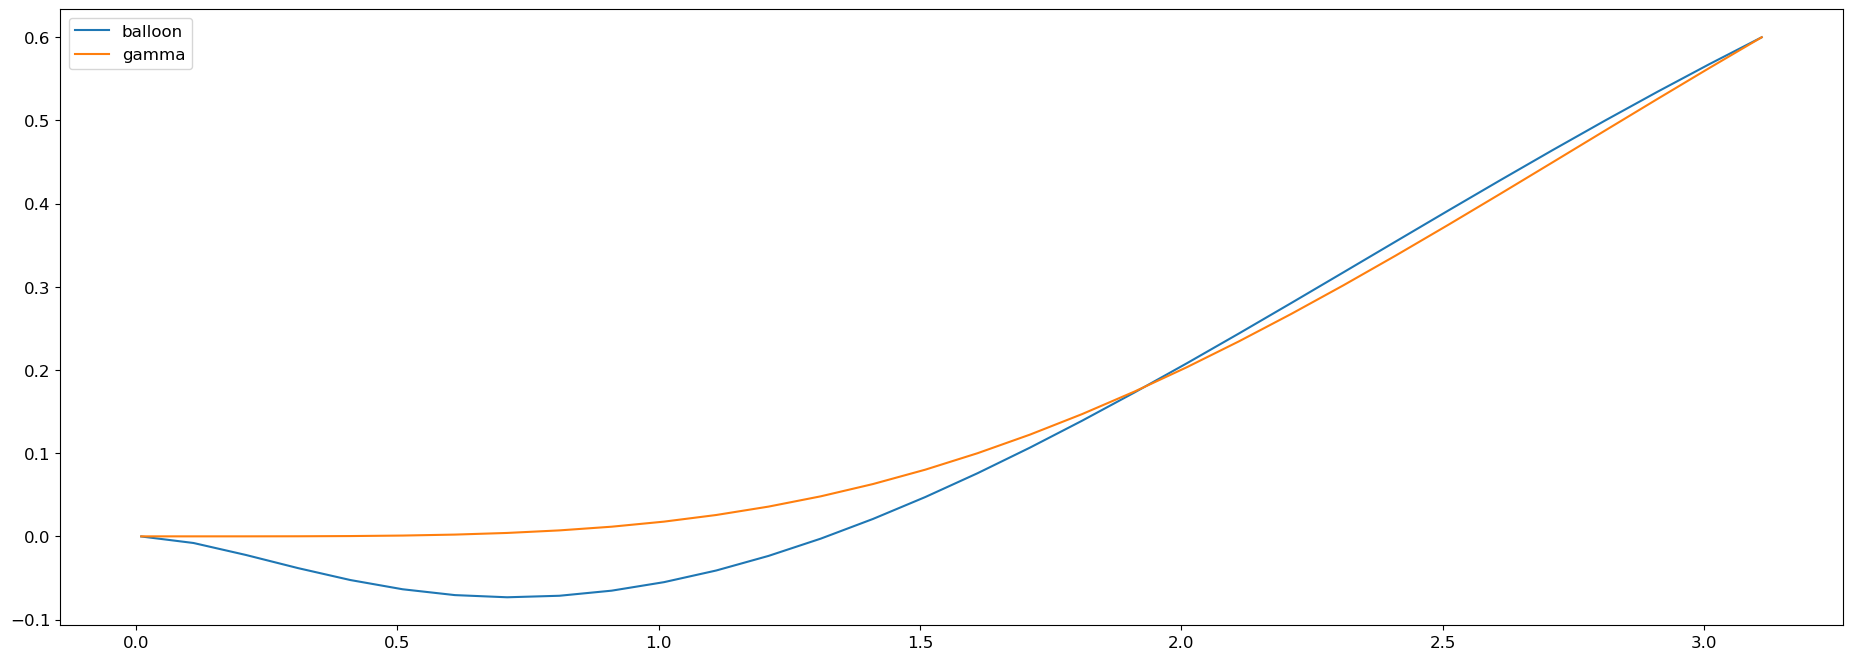

In [81]:
plt.figure(figsize=(23, 8))
t_res_activ, res_activ = hrf.resample_to_TR(local_activation_320)
plt.plot(t_res_activ/1e3, balloon/np.max(balloon)*0.6, label='balloon')
plt.plot(t_res_activ/1e3, gamma/np.max(gamma)*0.6, label='gamma')
plt.legend()